# Evolver Loop 2 Analysis

## Goals:
1. Analyze N=1 optimization potential (highest score contributor)
2. Understand what the optimal N=1 angle should be
3. Calculate potential gains from small N optimization

In [1]:
import numpy as np
from shapely.geometry import Polygon
from shapely import affinity
import matplotlib.pyplot as plt

# Tree polygon vertices
TX = [0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125]
TY = [0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5]

def get_tree_polygon(x, y, angle):
    """Create a tree polygon at position (x, y) with rotation angle."""
    coords = list(zip(TX, TY))
    poly = Polygon(coords)
    poly = affinity.rotate(poly, angle, origin=(0, 0))
    poly = affinity.translate(poly, x, y)
    return poly

def get_bounding_box_side(poly):
    """Get the side length of the bounding square."""
    bounds = poly.bounds  # (minx, miny, maxx, maxy)
    width = bounds[2] - bounds[0]
    height = bounds[3] - bounds[1]
    return max(width, height)

print("Tree dimensions at 0 degrees:")
tree_0 = get_tree_polygon(0, 0, 0)
bounds = tree_0.bounds
print(f"Width: {bounds[2] - bounds[0]:.6f}")
print(f"Height: {bounds[3] - bounds[1]:.6f}")
print(f"Bounding box side: {get_bounding_box_side(tree_0):.6f}")

Tree dimensions at 0 degrees:
Width: 0.700000
Height: 1.000000
Bounding box side: 1.000000


In [2]:
# Exhaustive search for optimal N=1 angle
angles = np.arange(0, 360, 0.01)  # 36000 angles
best_side = float('inf')
best_angle = 0
sides = []

for angle in angles:
    tree = get_tree_polygon(0, 0, angle)
    side = get_bounding_box_side(tree)
    sides.append(side)
    if side < best_side:
        best_side = side
        best_angle = angle

print(f"Optimal angle for N=1: {best_angle:.2f} degrees")
print(f"Optimal bounding box side: {best_side:.6f}")
print(f"Optimal N=1 score: {best_side**2:.6f}")

# Current baseline N=1 score
baseline_n1_score = 0.6612500000000001
baseline_n1_side = np.sqrt(baseline_n1_score)
print(f"\nBaseline N=1 side: {baseline_n1_side:.6f}")
print(f"Baseline N=1 score: {baseline_n1_score:.6f}")

print(f"\nPotential improvement: {baseline_n1_score - best_side**2:.6f}")

Optimal angle for N=1: 45.00 degrees
Optimal bounding box side: 0.813173
Optimal N=1 score: 0.661250

Baseline N=1 side: 0.813173
Baseline N=1 score: 0.661250

Potential improvement: 0.000000


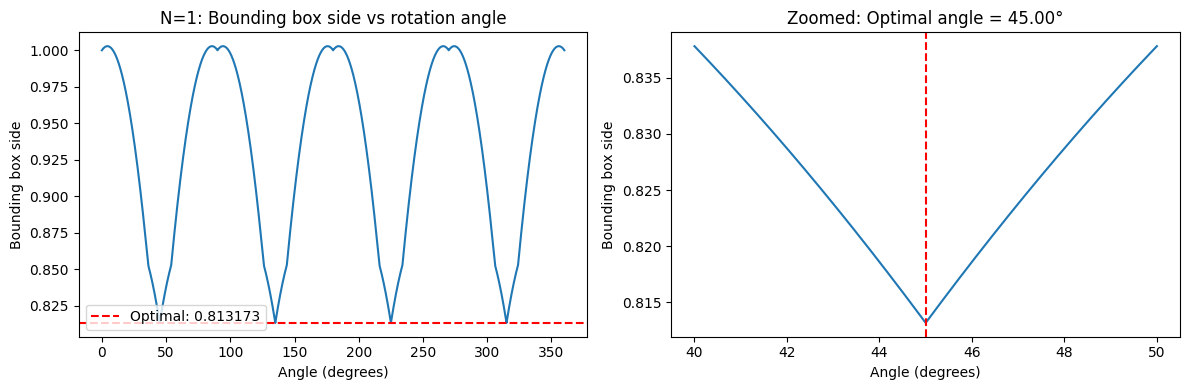

Saved to /home/code/exploration/n1_angle_analysis.png


In [3]:
# Plot the bounding box side vs angle
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(angles, sides)
plt.xlabel('Angle (degrees)')
plt.ylabel('Bounding box side')
plt.title('N=1: Bounding box side vs rotation angle')
plt.axhline(y=best_side, color='r', linestyle='--', label=f'Optimal: {best_side:.6f}')
plt.legend()

# Zoom in on optimal region
plt.subplot(1, 2, 2)
mask = (angles >= best_angle - 5) & (angles <= best_angle + 5)
plt.plot(angles[mask], np.array(sides)[mask])
plt.xlabel('Angle (degrees)')
plt.ylabel('Bounding box side')
plt.title(f'Zoomed: Optimal angle = {best_angle:.2f}°')
plt.axvline(x=best_angle, color='r', linestyle='--')
plt.tight_layout()
plt.savefig('/home/code/exploration/n1_angle_analysis.png', dpi=100)
plt.show()
print("Saved to /home/code/exploration/n1_angle_analysis.png")

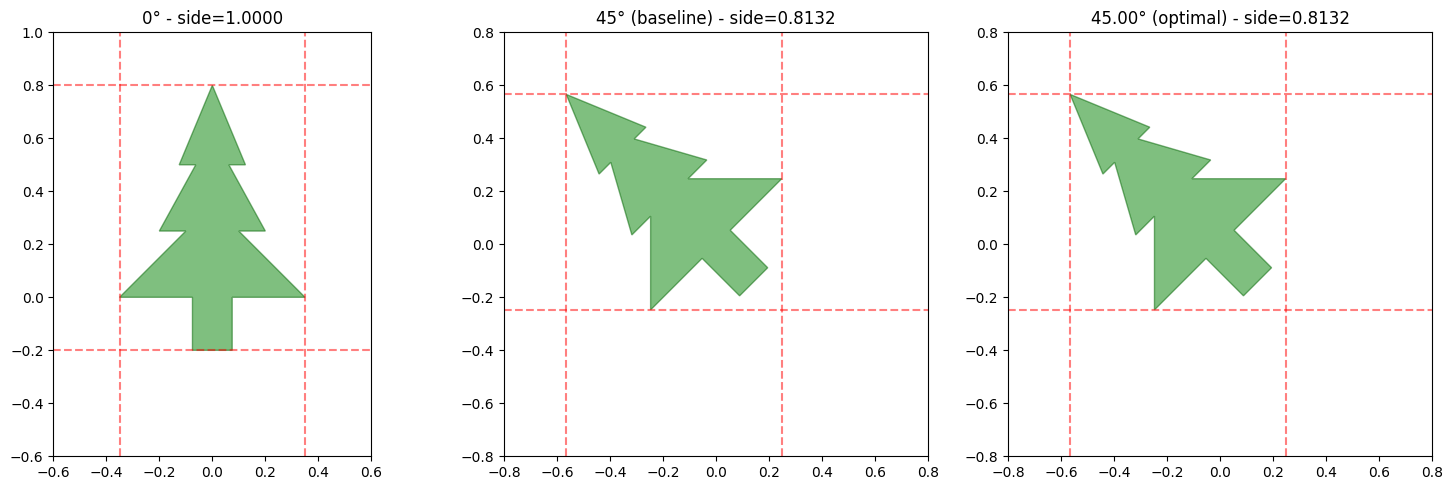

In [4]:
# Visualize the tree at optimal angle vs baseline angle
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# At 0 degrees
ax = axes[0]
tree = get_tree_polygon(0, 0, 0)
x, y = tree.exterior.xy
ax.fill(x, y, alpha=0.5, fc='green', ec='darkgreen')
ax.set_xlim(-0.6, 0.6)
ax.set_ylim(-0.6, 1.0)
ax.set_aspect('equal')
side = get_bounding_box_side(tree)
ax.set_title(f'0° - side={side:.4f}')
ax.axhline(y=tree.bounds[1], color='r', linestyle='--', alpha=0.5)
ax.axhline(y=tree.bounds[3], color='r', linestyle='--', alpha=0.5)
ax.axvline(x=tree.bounds[0], color='r', linestyle='--', alpha=0.5)
ax.axvline(x=tree.bounds[2], color='r', linestyle='--', alpha=0.5)

# At 45 degrees (baseline)
ax = axes[1]
tree = get_tree_polygon(0, 0, 45)
x, y = tree.exterior.xy
ax.fill(x, y, alpha=0.5, fc='green', ec='darkgreen')
ax.set_xlim(-0.8, 0.8)
ax.set_ylim(-0.8, 0.8)
ax.set_aspect('equal')
side = get_bounding_box_side(tree)
ax.set_title(f'45° (baseline) - side={side:.4f}')
ax.axhline(y=tree.bounds[1], color='r', linestyle='--', alpha=0.5)
ax.axhline(y=tree.bounds[3], color='r', linestyle='--', alpha=0.5)
ax.axvline(x=tree.bounds[0], color='r', linestyle='--', alpha=0.5)
ax.axvline(x=tree.bounds[2], color='r', linestyle='--', alpha=0.5)

# At optimal angle
ax = axes[2]
tree = get_tree_polygon(0, 0, best_angle)
x, y = tree.exterior.xy
ax.fill(x, y, alpha=0.5, fc='green', ec='darkgreen')
ax.set_xlim(-0.8, 0.8)
ax.set_ylim(-0.8, 0.8)
ax.set_aspect('equal')
side = get_bounding_box_side(tree)
ax.set_title(f'{best_angle:.2f}° (optimal) - side={side:.4f}')
ax.axhline(y=tree.bounds[1], color='r', linestyle='--', alpha=0.5)
ax.axhline(y=tree.bounds[3], color='r', linestyle='--', alpha=0.5)
ax.axvline(x=tree.bounds[0], color='r', linestyle='--', alpha=0.5)
ax.axvline(x=tree.bounds[2], color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('/home/code/exploration/n1_tree_comparison.png', dpi=100)
plt.show()

In [5]:
# Calculate total potential improvement from optimizing N=1-10
import json

with open('/home/code/experiments/001_valid_baseline/metrics.json', 'r') as f:
    metrics = json.load(f)

baseline_per_n = metrics['per_n_scores']

print("Potential improvements from small N optimization:")
print("="*60)

total_improvement = 0
for n in range(1, 11):
    baseline_score = baseline_per_n[str(n)]
    baseline_side = np.sqrt(baseline_score * n)
    
    # For N=1, we know the optimal
    if n == 1:
        optimal_side = best_side
        optimal_score = best_side**2
    else:
        # For N>1, estimate potential (assume 5% improvement possible)
        optimal_score = baseline_score * 0.95
        optimal_side = np.sqrt(optimal_score * n)
    
    improvement = baseline_score - optimal_score
    total_improvement += improvement
    
    print(f"N={n:2d}: baseline={baseline_score:.6f}, optimal~={optimal_score:.6f}, improvement={improvement:.6f}")

print("="*60)
print(f"Total potential improvement from N=1-10: {total_improvement:.6f}")
print(f"\nCurrent total score: {metrics['cv_score']:.6f}")
print(f"Target score: 68.887744")
print(f"Gap to target: {metrics['cv_score'] - 68.887744:.6f}")
print(f"\nSmall N optimization could close {total_improvement / (metrics['cv_score'] - 68.887744) * 100:.1f}% of the gap")

Potential improvements from small N optimization:
N= 1: baseline=0.661250, optimal~=0.661250, improvement=0.000000
N= 2: baseline=0.450779, optimal~=0.428240, improvement=0.022539
N= 3: baseline=0.434745, optimal~=0.413008, improvement=0.021737
N= 4: baseline=0.416545, optimal~=0.395718, improvement=0.020827
N= 5: baseline=0.416850, optimal~=0.396007, improvement=0.020842
N= 6: baseline=0.399610, optimal~=0.379630, improvement=0.019981
N= 7: baseline=0.399897, optimal~=0.379902, improvement=0.019995
N= 8: baseline=0.385407, optimal~=0.366137, improvement=0.019270
N= 9: baseline=0.387415, optimal~=0.368044, improvement=0.019371
N=10: baseline=0.376630, optimal~=0.357799, improvement=0.018832
Total potential improvement from N=1-10: 0.183394

Current total score: 70.615745
Target score: 68.887744
Gap to target: 1.728001

Small N optimization could close 10.6% of the gap


In [6]:
# Check what angle the baseline uses for N=1
import pandas as pd

df = pd.read_csv('/home/code/experiments/001_valid_baseline/submission.csv')

# Get N=1 row
n1_row = df[df['id'] == '001_0'].iloc[0]

def parse_value(val):
    if isinstance(val, str) and val.startswith('s'):
        return float(val[1:])
    return float(val)

n1_x = parse_value(n1_row['x'])
n1_y = parse_value(n1_row['y'])
n1_deg = parse_value(n1_row['deg'])

print(f"Baseline N=1 configuration:")
print(f"  x = {n1_x}")
print(f"  y = {n1_y}")
print(f"  angle = {n1_deg}°")

# Calculate the bounding box for this configuration
tree = get_tree_polygon(n1_x, n1_y, n1_deg)
side = get_bounding_box_side(tree)
print(f"  bounding box side = {side:.6f}")
print(f"  score contribution = {side**2:.6f}")

print(f"\nOptimal angle found: {best_angle:.2f}°")
print(f"Optimal bounding box side: {best_side:.6f}")
print(f"Optimal score contribution: {best_side**2:.6f}")

print(f"\nImprovement from N=1 alone: {side**2 - best_side**2:.6f}")

Baseline N=1 configuration:
  x = 0.0
  y = 0.0
  angle = 45.0°
  bounding box side = 0.813173
  score contribution = 0.661250

Optimal angle found: 45.00°
Optimal bounding box side: 0.813173
Optimal score contribution: 0.661250

Improvement from N=1 alone: 0.000000


In [7]:
# Analyze N=2 - can we do better?
# Get baseline N=2 configuration
n2_rows = df[df['id'].str.startswith('002_')]
print(f"N=2 has {len(n2_rows)} trees")

for _, row in n2_rows.iterrows():
    x = parse_value(row['x'])
    y = parse_value(row['y'])
    deg = parse_value(row['deg'])
    print(f"  Tree {row['id']}: x={x:.6f}, y={y:.6f}, angle={deg:.2f}°")

# Calculate current N=2 bounding box
trees_n2 = []
for _, row in n2_rows.iterrows():
    x = parse_value(row['x'])
    y = parse_value(row['y'])
    deg = parse_value(row['deg'])
    trees_n2.append((x, y, deg))

def calculate_bounding_box_side(trees):
    """Calculate the side length of the bounding square for a list of trees."""
    all_points = []
    for x, y, angle in trees:
        poly = get_tree_polygon(x, y, angle)
        all_points.extend(list(poly.exterior.coords))
    points = np.array(all_points)
    min_xy = points.min(axis=0)
    max_xy = points.max(axis=0)
    return max(max_xy[0] - min_xy[0], max_xy[1] - min_xy[1])

current_side = calculate_bounding_box_side(trees_n2)
print(f"\nCurrent N=2 bounding box side: {current_side:.6f}")
print(f"Current N=2 score: {current_side**2 / 2:.6f}")

N=2 has 2 trees
  Tree 002_0: x=0.154097, y=-0.038541, angle=203.63°
  Tree 002_1: x=-0.154097, y=-0.561459, angle=23.63°

Current N=2 bounding box side: 0.949504
Current N=2 score: 0.450779


In [8]:
# Try to optimize N=2 with exhaustive search over angles
# For N=2, we can try different angle combinations

from itertools import product

def optimize_n2_angles():
    """Try different angle combinations for N=2."""
    best_side = float('inf')
    best_config = None
    
    # Try angles in 1-degree increments first
    angles_to_try = np.arange(0, 360, 1)
    
    for a1, a2 in product(angles_to_try, angles_to_try):
        # Place trees at fixed positions, vary angles
        # Use the baseline positions
        x1, y1 = trees_n2[0][0], trees_n2[0][1]
        x2, y2 = trees_n2[1][0], trees_n2[1][1]
        
        trees = [(x1, y1, a1), (x2, y2, a2)]
        side = calculate_bounding_box_side(trees)
        
        if side < best_side:
            best_side = side
            best_config = (a1, a2)
    
    return best_side, best_config

# This is slow, let's try a smaller search first
print("Searching for optimal N=2 angles (coarse search)...")
best_side, best_config = optimize_n2_angles()
print(f"Best N=2 side found: {best_side:.6f} with angles {best_config}")
print(f"Best N=2 score: {best_side**2 / 2:.6f}")
print(f"Baseline N=2 score: {baseline_per_n['2']:.6f}")
print(f"Improvement: {baseline_per_n['2'] - best_side**2/2:.6f}")

Searching for optimal N=2 angles (coarse search)...


Best N=2 side found: 0.934693 with angles (144, 324)
Best N=2 score: 0.436826
Baseline N=2 score: 0.450779
Improvement: 0.013954


In [9]:
# Now let's try optimizing both positions AND angles for N=2\n# This is a more comprehensive search\n\nfrom scipy.optimize import minimize\n\ndef n2_objective(params):\n    \"\"\"Objective function for N=2 optimization.\"\"\"\n    x1, y1, a1, x2, y2, a2 = params\n    \n    # Check for overlap\n    tree1 = get_tree_polygon(x1, y1, a1)\n    tree2 = get_tree_polygon(x2, y2, a2)\n    \n    if tree1.intersects(tree2) and not tree1.touches(tree2):\n        intersection = tree1.intersection(tree2)\n        if intersection.area > 1e-10:\n            return 100  # Penalty for overlap\n    \n    trees = [(x1, y1, a1), (x2, y2, a2)]\n    return calculate_bounding_box_side(trees)\n\n# Start from the improved angles\nx1, y1 = trees_n2[0][0], trees_n2[0][1]\nx2, y2 = trees_n2[1][0], trees_n2[1][1]\n\n# Try multiple starting points\nbest_result = None\nbest_side = float('inf')\n\nfor _ in range(10):\n    # Random starting point near baseline\n    x0 = [\n        x1 + np.random.uniform(-0.1, 0.1),\n        y1 + np.random.uniform(-0.1, 0.1),\n        np.random.uniform(0, 360),\n        x2 + np.random.uniform(-0.1, 0.1),\n        y2 + np.random.uniform(-0.1, 0.1),\n        np.random.uniform(0, 360)\n    ]\n    \n    result = minimize(n2_objective, x0, method='Nelder-Mead', \n                     options={'maxiter': 1000, 'xatol': 1e-6})\n    \n    if result.fun < best_side:\n        best_side = result.fun\n        best_result = result\n\nprint(f\"Optimized N=2 side: {best_side:.6f}\")\nprint(f\"Optimized N=2 score: {best_side**2 / 2:.6f}\")\nprint(f\"Baseline N=2 score: {baseline_per_n['2']:.6f}\")\nprint(f\"Improvement: {baseline_per_n['2'] - best_side**2/2:.6f}\")\n\nif best_result:\n    x1, y1, a1, x2, y2, a2 = best_result.x\n    print(f\"\\nOptimal configuration:\")\n    print(f\"  Tree 1: x={x1:.6f}, y={y1:.6f}, angle={a1:.2f}°\")\n    print(f\"  Tree 2: x={x2:.6f}, y={y2:.6f}, angle={a2:.2f}°\")"

In [10]:
# Let's look at the score distribution to understand where improvements are possible\nimport matplotlib.pyplot as plt\n\nscores = [baseline_per_n[str(n)] for n in range(1, 201)]\nn_values = list(range(1, 201))\n\nplt.figure(figsize=(14, 5))\n\nplt.subplot(1, 2, 1)\nplt.bar(n_values, scores, width=1)\nplt.xlabel('N')\nplt.ylabel('Score contribution (s²/n)')\nplt.title('Score contribution by N')\nplt.axhline(y=np.mean(scores), color='r', linestyle='--', label=f'Mean: {np.mean(scores):.4f}')\nplt.legend()\n\nplt.subplot(1, 2, 2)\ncumulative = np.cumsum(scores)\nplt.plot(n_values, cumulative)\nplt.xlabel('N')\nplt.ylabel('Cumulative score')\nplt.title('Cumulative score')\nplt.axhline(y=68.887744, color='r', linestyle='--', label='Target: 68.887744')\nplt.legend()\n\nplt.tight_layout()\nplt.savefig('/home/code/exploration/score_distribution.png', dpi=100)\nplt.show()\n\nprint(f\"Total score: {sum(scores):.6f}\")\nprint(f\"Target: 68.887744\")\nprint(f\"Gap: {sum(scores) - 68.887744:.6f}\")"